In [1]:
import praw
import pandas as pd
import numpy as np
import emoji
import unicodedata

from transformers import AutoTokenizer, pipeline
from sentence_transformers import SentenceTransformer, util
import spacy
import torch
import matplotlib.pyplot as plt

from tqdm import tqdm


reddit = praw.Reddit("project")
header = {"User-Agent": "my-bot/0.0.1 by u/Karmz0a"}

/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


add demo mode that only uses 15 posts
Input String + Search Subreddits
filter out meme subs, make sure theyre relevant, check for satire
search directly for comments, not posts -> comments

In [2]:
topic = input()
demo = False

subreddit = reddit.subreddit(topic)
count = 100 if subreddit.subscribers < 1000000 else 100
non_sticky = []
i = 0
for submission in subreddit.hot(limit = (count + 100)):
    if submission.stickied or submission.num_comments == 0:
        continue
    else:
        i = i + 1
        non_sticky.append(submission)
        if i == count:
            break

data = []
for submission in non_sticky:
    
    submission.comments.replace_more(limit = None)
    commentList = submission.comments.list()
    for comment in commentList:
        data.append({
            "author": comment.author,
            "original post" : submission.id,
            "upvotes": comment.score,
            "body": emoji.demojize(comment.body, delimiters=(":", ":")).replace("\n", " ").replace("\r", " "),
        })

ValueError: An invalid value was specified for display_name. Check that the argument for the display_name parameter is not empty.

Data Cleaning

In [ ]:
commentFrame = pd.DataFrame(data)

commentFrame = commentFrame[(commentFrame["author"] != "AutoModerator") & 
                            (commentFrame["author"].notna()) &
                            (commentFrame["body"] != "[removed]")
                            ].drop_duplicates()

commentFrame["body"] = commentFrame["body"].apply(lambda x: unicodedata.normalize("NFC", x ))

conditions = [
    commentFrame["upvotes"] == 0,
    commentFrame["upvotes"] > 0,
    commentFrame["upvotes"] < 0
]
choices = [
    0,
    np.log10(commentFrame["upvotes"]),
    -np.log10(-commentFrame["upvotes"])
]

commentFrame["upvoteScale"] = np.select(conditions, choices, default = np.nan)



/opt/homebrew/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/homebrew/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Sentiment Analysis
give user a list of spaCy labels to choose what is relevant and what is not

filter SPACY keywords -> work of art, product, org person etc

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")   # NVIDIA GPU
elif torch.backends.mps.is_available():
    device = torch.device("mps")    # Apple Silicon GPU (Metal Performance Shaders)
else:
    device = torch.device("cpu")    # fallback
nlp = spacy.load("en_core_web_sm", disable= ["parser", "tagger"])
embedder = SentenceTransformer("all-MiniLM-L6-v2", device = device)

spacy_entities = ["ORG", "PRODUCT", "PERSON", "WORK_OF_ART", "NORP", "GPE", "LOC", "LAW", "EVENT", "FAC"] # make this multiple choice for the user
entity = []
for doc in nlp.pipe(commentFrame["body"], batch_size= 100, n_process=-1):
    for ent in doc.ents:
        entity.append((ent.text, ent.label_))
        


df_entities = pd.DataFrame(entity, columns=["entity", "label"])
e = df_entities[df_entities["label"].isin(spacy_entities)].value_counts().head(18)
print(e)
top_ent = [idx[0] for idx in e.index]


comments = commentFrame["body"].tolist()
query_emb =  embedder.encode(top_ent, normalize_embeddings= True)

comment_emb = embedder.encode(comments, normalize_embeddings= True, show_progress_bar= True, batch_size= 64)

relevance = embedder.similarity(query_emb, comment_emb)
best_score = torch.max(relevance, dim = 0).values.tolist()

relevance = embedder.similarity(query_emb, comment_emb)
best_score = torch.max(relevance, dim = 0).values.tolist()
commentFrame["relevance"] =  best_score

cutoff = np.percentile(commentFrame["relevance"], 10)
commentFrame = commentFrame[commentFrame["relevance"] > cutoff]

/opt/homebrew/lib/python3.11/site-packages/spacy/pipeline/lemmatizer.py:188: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
/opt/homebrew/lib/python3.11/site-packages/spacy/pipeline/lemmatizer.py:188: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
/opt/homebrew/lib/python3.11/site-packages/spacy/pipeline/lemmatizer.py:188: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
/opt/ho

entity        label  
Nintendo      ORG        694
Switch        PERSON     248
Switch 2      LAW        209
DLC           ORG        146
the Switch 2  PRODUCT    130
Switch 1      LAW        122
Switch 2      PERSON     111
Metroid       ORG         88
Pokemon       PERSON      73
devs          PERSON      70
Sony          ORG         68
Japan         GPE         67
Silksong      PERSON      66
              ORG         61
Xbox          ORG         57
NSO           ORG         51
Mario         PERSON      50
Hades 2       LAW         49
Name: count, dtype: int64


Batches: 100%|██████████| 138/138 [00:08<00:00, 16.96it/s]


In [ ]:
comments = commentFrame["body"].tolist()
if torch.cuda.is_available():
    device = torch.device("cuda:0")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")  
classifier = pipeline("sentiment-analysis", model = "AG6019/reddit-comment-sentiment-final", device = device)

label_map = {"LABEL_0": -1, "LABEL_1": 1}

batch_size = 64 if device.type != "cpu" else 8
results = []

for i in tqdm(range(0, len(comments), batch_size), desc = "sentiment analysis"):
    batch = comments[i:i+batch_size]
    sentiment = classifier(batch, truncation = True, max_length = 128)
    results.extend(sentiment)

commentFrame["sentimentLabel"] = [0 if r["score"] < 0.85 else label_map[r["label"]] for r in results]
commentFrame["sentimentScore"] = [r["score"] for r in results]

print(commentFrame.head())

Device set to use mps
sentiment analysis: 100%|██████████| 124/124 [01:31<00:00,  1.36it/s]

             author original post  upvotes  \
0        CelticSith       1nrjxv6      254   
2      PecanScrandy       1nrjxv6       74   
3         Quick_Hit       1nrjxv6       17   
4         meikaishi       1nrjxv6       26   
5  MarioFanatic64-2       1nrjxv6        4   

                                                                                                                                                              body  \
0                                                                                                                        OCD this generation is going to be :fire:   
2                                                                            Damn Switch 1 case with the Switch 2 hideous key card text truly worst of both worlds   
3                                                                                  Man the gamecube styled spine is what i liked about switch 2, bamco being lazy.   
4                                                          

Account for Sarcasm and Upvotes

In [ ]:
commentFrame["author"] = commentFrame["author"].astype(str)
commentFrame["AuthorAverageUpvotes"] = commentFrame.groupby("author")["upvoteScale"].transform("mean")
def avg_to_label(avg):
    if avg > 0.25:
        return "POSITIVE"
    elif avg < -0.25:
        return "NEGATIVE"
    else:
        return "NEUTRAL"

commentFrame["AverageUserSentiment"] = commentFrame.groupby("author")["sentimentLabel"].transform("mean")
commentFrame["AverageUserSentiment"] = commentFrame["AverageUserSentiment"].apply(avg_to_label)
print(commentFrame.head(5))
#print(commentFrame["sentimentLabel"].value_counts())

#print(commentFrame["AverageUserSentiment"].value_counts())

             author original post  upvotes  \
0        CelticSith       1nrjxv6      254   
2      PecanScrandy       1nrjxv6       74   
3         Quick_Hit       1nrjxv6       17   
4         meikaishi       1nrjxv6       26   
5  MarioFanatic64-2       1nrjxv6        4   

                                                                                                                                                              body  \
0                                                                                                                        OCD this generation is going to be :fire:   
2                                                                            Damn Switch 1 case with the Switch 2 hideous key card text truly worst of both worlds   
3                                                                                  Man the gamecube styled spine is what i liked about switch 2, bamco being lazy.   
4                                                          

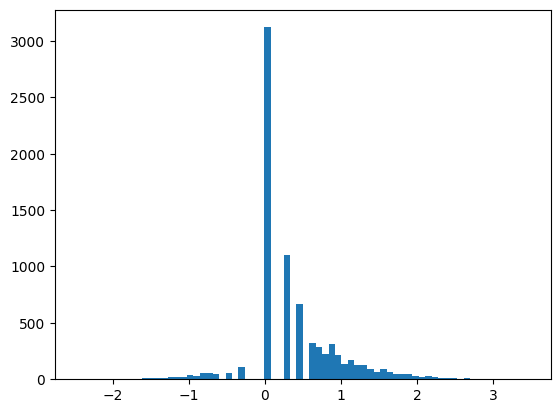

sentimentLabel
 1    4195
 0    2504
-1    1207
Name: count, dtype: int64


In [ ]:
commentFrame.to_pickle("comments.pkl")
plt.hist(commentFrame["upvoteScale"], bins = 70)
plt.show()
print(commentFrame["sentimentLabel"].value_counts())


In [ ]:
pd.set_option("display.max_colwidth", 200)
print(commentFrame["sentimentLabel"].mean())
print(commentFrame[commentFrame["upvotes"] < 0]["sentimentLabel"].mean())




0.3779408044523147
0.2365747460087083


sentiment assortivity
overall sentiment of the subreddit- battle ground or agreement
overall sentiment of each user, compare negativity rate to 